## Erschließungsstrategien für unbekannten Wortschatz von DaF-Lernenden an spanischen Universitäten
# Datenanalyse der Hauptstudie 2018

#### Daten importieren

In [294]:
import pandas as pd
import math
import matplotlib
import numpy as np
from biofes import biplot
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans, AgglomerativeClustering
from adjustText import adjust_text
import seaborn as sns
sns.set(style="whitegrid") #"darkgrid"...
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [147]:
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt

In [159]:
def get_colors(df, colormap=plt.cm.RdBu, vmin=None, vmax=None):
    """
    Function to automatically gets a colormap for all the values passed in,
    Have the option to normalise the colormap.
    :params:
        values list(): list of int() or str() that have all the values that need a color to be map
        to. In case of a list() of str(), the try/except use the range(len()) to map a colour
        colormap cm(): type of colormap that need to be used. All can be found here:
            https://matplotlib.org/examples/color/colormaps_reference.html
        vmin, vmax int(): Number to normalise the return of the colourmap if needed a Normalised colourmap
    :return:
        colormap cm.colormap(): An array of RGBA values
    Original version found on stackerOverflow (w/o the try/except) but cannot find it back
    """
    values = df.columns
    norm = plt.Normalize(vmin, vmax)
    try:
        return colormap(norm(values))
    except (AttributeError, TypeError):  # May happen when gives a list of categorical values
        return colormap(norm(range(len(values))))


def create_bars(df, ax, y_pos, colors, left_gap):
    """
    Loop through the columns and create an horizontal bar for each.
    First it creates all the left bars, for all the columns, then the
    one on the right. Each time, it add the distance from the previous bar.
    If 'left_invisible_bar' is passed, it will create a empty gap on the left
    before the first bar to centred the plot in the middle
    :params:
        df df(): The dataframe containing the information
        ax plt(): The subplot to draw on
        y_pos np.array(): an array of the number of bars (likert items)
        colors np.array(): an array containing the colors for the different answers
        left_gap np.array(): the empty left gap needed to
            centre the stacked bar
    :return:
        patch_handles list(): A list containing the drawn horizontal stacked bars
    """
    patch_handles = []
    for i, c in enumerate(df.columns):
        d = np.array(df[c])
        new_bar = ax.barh(y_pos,
                          d,
                          color=colors[i],
                          align='center',
                          left=left_gap)
        patch_handles.append(new_bar)
        # accumulate the left-hand offsets
        left_gap += d
    return patch_handles


def compute_middle_sum(df, first_half, middle):
    try:
        return df[first_half].sum(axis=1) + df[middle] *.5
    except ValueError:  # In case middle value is none
        return df[first_half].sum(axis=1)


def get_middle(inputlist):
    """
    Return the first half of a list and the middle element
    In case the list can be splitted in two equal element,
    return only the first half
    :params:
        inputlist list(): list to split
    :returns:
        first_half list(): list of the first half element
        middle_elmenet int():
    """
    middle = float(len(inputlist) /2)
    if len(inputlist) % 2 !=0:
        # If the list has a true middle element it needs
        # to be accessed by adding 0.5 to the index
        middle = int(middle + 0.5) - 1
        # In the case of a true middle is found, the first half
        # is all elements except the middle
        first_half = middle
        return inputlist[middle], inputlist[0:first_half]
    # In case of not true middle can be found (in case the
    # list has a lenght of an even number, it can only
    # return the first half. The middle value is None
    return None, inputlist[:int(middle)]


def get_total_mid_answers(df):
    """
    Get the list of the columns
    """
    middle, first_half = get_middle(df.columns)
    return compute_middle_sum(df, first_half, middle)


# TODO Simplify this function
def compute_percentage(df, by_row=True, by_col=False):
    """
    Transform every cell into a percentage
    """
    def compute_percentage(row, total=None):
        if total is None:
            total = np.sum(row)
        return [np.round(((x /total) *100), 2) for x in row]

    if by_row is True and by_col is False:
        return np.array(df.apply(compute_percentage, axis=1))

    elif by_col is True and by_row is False:
        return np.array(df.apply(compute_percentage, axis=0))

    elif by_row is True and by_col is True:
        total = df.values.sum()
        return np.array(df.apply(compute_percentage, total=total))


def normalise_per_row(df):
    df = df.div(df.sum(axis=1), axis=0)
    return df.multiply(100)


def add_labels(df, ax, bars, rotation=0):
    """
    """
    # Create percentage for each cells to have the right annotation
    percentages = compute_percentage(df)
    # go through all of the bar segments and annotate
    for j in range(len(bars)):
        for i, bar in enumerate(bars[j].get_children()):
            bl = bar.get_xy()
            x = 0.5 *bar.get_width() +bl[0]
            y = 0.5 *bar.get_height() +bl[1]
            ax.text(x, y, "{}".format(percentages[i, j]), ha='center', rotation=rotation)


def draw_middle_line(normalise, longest_middle):
    """
    """
    # Draw a dashed line on the middle to visualise it
    if normalise:
        z = plt.axvline(100, linestyle='--', color='black', alpha=.5)
    else:
        z = plt.axvline(longest_middle, linestyle='--', color='black', alpha=.5)
    # Plot the line behind the barchart
    z.set_zorder(-1)


def drawing_x_labels(normalise, complete_longest, longest_middle):
    """
    """
    # Create the values with the same length as the xlim
    if normalise:
        xvalues = range(0, 210, 10)
        xlabels = [str(math.floor(abs(x - 100))) for x in xvalues]
    else:
        print('NOT normalised')
        xvalues = [math.floor(i - (longest_middle %5))
                   for i in range(0, int(complete_longest),
                                  int(int(longest_middle)/ 5))]
        xlabels = [str(math.floor(abs(x - longest_middle))) for x in xvalues]
    plt.xticks(xvalues, xlabels)


def likert_scale(df, normalise=True, labels=True, middle_line=True, legend=True, rotation=0):
    """
    The idea is to create a fake bar on the left to center the bar on the same point.
    :params:
    :return:
    """
    # Create the figure object
    fig = plt.figure(figsize=(10, 8))
    # Create an axes object in the figure
    ax = fig.add_subplot(111)

    # Generate an array of colors based on different colormap. The default value
    # Use a divergent colormap.
    colors = get_colors(df)

    # Get the position of each bar for all the items
    y_pos = np.arange(len(df.index))

    if normalise:
        df = normalise_per_row(df)

    # Compute the middle of the possible answers. Assuming the answers are columns
    # Get the sum of the middles +.5 if middle value and without .5 if splitted in 2
    # equal divides
    middles = get_total_mid_answers(df)

    # Calculate the longest middle bar to set up the middle of the x-axis for the x-lables
    # and plot the middle line
    if normalise:
        longest_middle = 100
    else:
        longest_middle = middles.max()
    print('LONGEST MIDDLE: {}'.format(longest_middle))

    # Create the left bar to centre the barchart in the middle
    left_invisible_bar = np.array((middles - longest_middle).abs())

    # Calculate the longest bar with the left gap in it to plot the x_value at the end
    # Calculate the total of the longest bar to have the appropriate width +
    # the invisible bar in case it is used to center everything
    complete_longest = (df.sum(axis=1) + left_invisible_bar).max()

    # Create the horizontal bars
    bars = create_bars(df, ax, y_pos, colors, left_invisible_bar)

    # Set up the limit from 0 to the longest total barchart
    # Keeping this drawing before drawing_x_labels or it will failed to draw
    # all the labels on the right side
    ax.set_xlim([-0.5, complete_longest + 0.5])

    # Drawing x_labels
    drawing_x_labels(normalise, complete_longest, longest_middle)
    ax.set_xlabel('Percentages')

    # Setting up the y-axis
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df.index)

    # Add labels to each box
    if labels:
        add_labels(df, ax, bars, rotation)

    # Create a line on the middle
    if middle_line:
        draw_middle_line(normalise, longest_middle)

    # Add legend
    if legend:
        ax.legend(bars, df.columns)


def count_unique_value(df, colnames, rename_columns=False, dropna=False, normalize=False):
    """
    Count the values of different columns and transpose the count
    :params:
        :df pd.df(): dataframe containing the data
        :colnames list(): list of strings corresponding to the column header to select the right column
    :return:
        :result_df pd.df(): dataframe with the count of each answer for each columns
    """
    # Subset the columns
    df_sub = df[colnames]

    if rename_columns is True:
        df_sub.columns = [s.split('[', 1)[1].split(']')[0] for s in colnames]

    # Calculate the counts for them
    df_sub = df_sub.apply(pd.Series.value_counts, dropna=dropna, normalize=normalize)
    # Transpose the column to row to be able to plot a stacked bar chart
    return df_sub.transpose()

LONGEST MIDDLE: 100


IndexError: too many indices for array

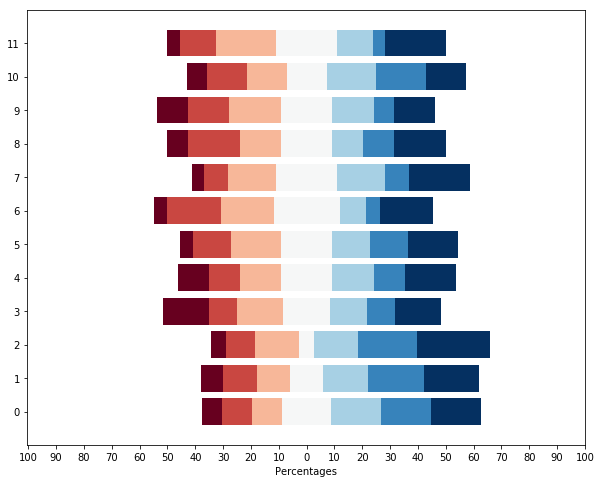

In [166]:
likert_scale(Daten[Liste_A_Q2][:12])

In [2]:
Daten = pd.read_pickle('D:\Daten\DISS\Daten\Estrategias_Estudiantes_2018_ber')

In [3]:
Daten.shape

(303, 358)

In [4]:
Daten.head(3)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,D-Q8b22a_5,D-Q8b22a_6,D-Q8b22a_7,D-Q8b22a_7_TEXT,D-Q8b22b,D-Q8b22c,D-Q9_1,D-Q9_2,E-Q1,porc_nan
0,2018-02-07 13:36:43,2018-02-07 13:50:01,0,83.47.61.251,100,797,1,2018-02-07 13:50:03,R_30ugRXCZSq8xMsk,0,...,0,0,0,0,0,0,0,1,0,59.523810
1,2018-02-08 02:38:26,2018-02-08 03:09:12,0,84.126.137.166,100,1845,1,2018-02-08 03:09:13,R_1eV2zm3mlcaUK2x,0,...,0,0,0,0,0,0,0,1,0,55.238095
2,2018-02-08 03:47:29,2018-02-08 04:05:38,0,79.109.193.215,100,1089,1,2018-02-08 04:05:39,R_czEmSnFHhfZOTL3,0,...,0,0,0,0,0,0,0,1,0,58.095238


#### Glossar erstellen

Datei aufrufen, die in einem anderem Notebook erstellt und gespeichert wurde

In [5]:
gloss = pd.read_pickle('D:\Daten\DISS\Daten\Gloss2018')

Funktion, um Index (Name) einer Bezeichnung im Glossar zu finden:

In [6]:
def get_name_gloss(word):
    for i, val in enumerate(gloss[0]):
        if word.lower() in str(val).lower():
            return i, gloss.index[i]

Funktion, um Bezeichnung von Index im Glossar zu finden:

In [7]:
def get_name_glossind(word):
    for i, val in enumerate(gloss.index):
        if word.lower() in str(val).lower():
            return i, gloss.loc[val][0]

In [8]:
get_name_glossind('A-Q1')

(17,
 'Probablemente, en este texto encuentre palabras o grupos de palabras que no conoce aún. Sin embargo, seguro que logra entender algunas de estas palabras nuevas sin ayuda, bien enseguida o después de pensar un poco. Lea el texto y piense qué hace para descubrir el significado o la función de las palabras que desconoce. También puede pensar en otras situaciones en las que se haya encontrado con vocabulario nuevo.  ¿Qué estrategias o técnicas usa para averiguar el significado de palabras desconocidas? ¿Qué características de las palabras, frases o textos le ayudan?               Apunte todas sus ideas aquí:')

#### Untergruppen und Listen für die Analyse

In [9]:
Daten_A3 = Daten[Daten['A-Q3_27'] >= 1]

In [10]:
Daten_A3.shape

(300, 358)

In [11]:
Finished = Daten[Daten['Finished'] == '1'].reset_index(drop=True)

In [12]:
Finished.shape

(294, 358)

Liste erstellen:

In [13]:
Liste_A_Q2 = [col for col in Daten.columns if 'A-Q2' in col]

In [14]:
Liste_A_Q3 = [col for col in Daten.columns if 'A-Q3' in col]
Liste_A_Q3.pop(3)

'A-Q3_3_TEXT'

kann noch verbessert werden:

statt Spalte "3" (eigentlich 4, Python zählt ja ab 0) irgendwie "text"-Spalte weglassen

In [15]:
Liste_C_Q1 = [col for col in Finished.columns if 'C-Q1' in col]

##### Visualisierung

Funktion für Grafiken:

In [16]:
def graf_hist(D,l,sx,sy,nrow,ncol):
    fig = plt.figure(figsize=(sx,sy))
    for i, col in enumerate(l):
        plt.subplot(nrow,ncol,i+1)
        plt.hist(D[col].dropna(),color = '#0063A6')
        plt.xticks([1,2,3,4,5])
        plt.title(col,size=13)
    plt.show()

##### Korrelation

Funktion, um Daten mit bestimmtem Korrelationswert (z.B. über 0,5) zu erhalten:

In [17]:
def get_max_corr(df,col,lim = 0.5):
    return df[(df[col] > lim) & (df[col].dropna() < 0.99)][col]

### Cronbach's Alpha berechnen

In [18]:
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    calpha = nitems / float(nitems-1) * (1 - itemvars.sum() / float(tscores.var(ddof=1)))

    return calpha

In [19]:
CronbachAlpha(Daten[Liste_A_Q2])

0.25915134559344694

In [20]:
CronbachAlpha(Daten_A3[Liste_A_Q3])

0.8895811333745897

In [21]:
CronbachAlpha(Finished[Liste_C_Q1])

0.5104733681971647

In [22]:
Liste_A_Q = Liste_A_Q2 + Liste_A_Q3

In [23]:
Liste_AC_Q = Liste_A_Q + Liste_C_Q1

In [24]:
CronbachAlpha(Daten[Liste_AC_Q])

0.9092180930882015

### Zeitanalyse

In [25]:
Dur = pd.to_numeric(Finished['Duration (in seconds)'])

In [26]:
Dur.describe()

count       294.000000
mean       4713.979592
std       33957.223961
min         346.000000
25%         703.250000
50%        1066.000000
75%        1370.500000
max      535186.000000
Name: Duration (in seconds), dtype: float64

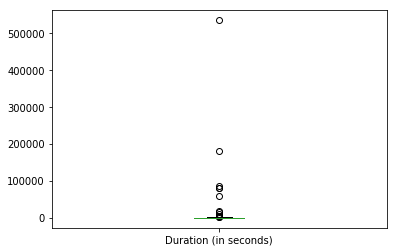

In [27]:
Dur.plot.box();

Überblick über die Beantwortungszeit und Darstellung in einem Boxplot, um Outlyers zu erkennen -> sollen nicht mit berücksichtigt werden (z.B. TN, die an einem Tag begonnen und später beendet haben...)

sinnvoll ist, eine Grenze bei ca. einer Stunde Beantwortungszeit (3600 sek) festzulegen

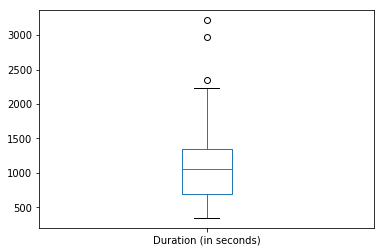

In [28]:
Dur[Dur < 4000].plot.box();

In [29]:
Dur[Dur < 4000].describe()

count     283.000000
mean     1076.784452
std       488.428468
min       346.000000
25%       695.000000
50%      1049.000000
75%      1344.000000
max      3215.000000
Name: Duration (in seconds), dtype: float64

In [30]:
(Dur[Dur < 4000].mean())/60

17.94640753828033

Schlussfolgerung:

durchschnittliche Beantwortungszeit liegt bei ca. 18min, wobei berücksichtigt werden muss, dass TN außerhalb des Unterrichts Pausen einlegen konnten und dass z.T. bei der Beantwortung im Unterricht mehr Zeit für Erklärungen/Einloggen/Abwarten... verwendet wurde

### Analyse der Strategiennutzung

#### A-Q2 (7 Hauptbereiche)

In [31]:
Daten[Liste_A_Q2].describe()

,A-Q2_1,A-Q2_2,A-Q2_3,A-Q2_4,A-Q2_5,A-Q2_6,A-Q2_7
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,2.557756,3.537954,3.792079,4.003300,3.402640,3.287129,4.333333
std,1.077677,0.878955,0.983138,1.014786,0.984781,1.156639,0.852214
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,4.000000
50%,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,5.000000
75%,3.000000,4.000000,4.500000,5.000000,4.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


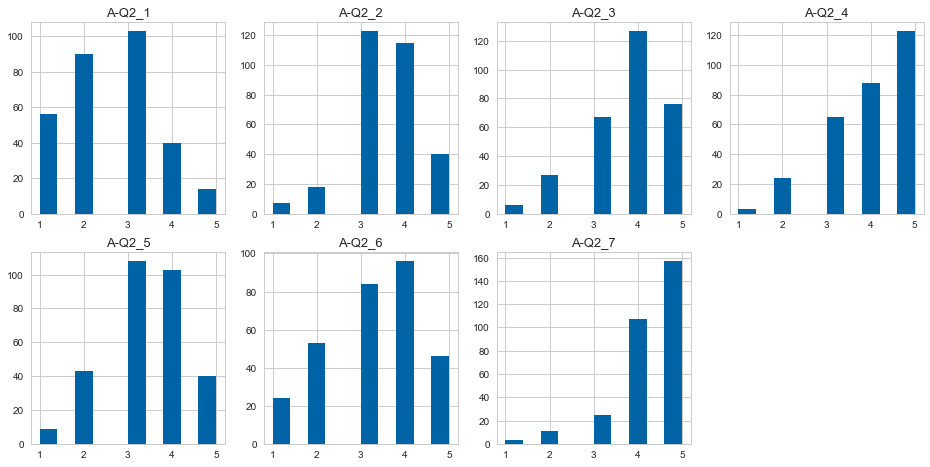

In [295]:
graf_hist(Daten,Liste_A_Q2,16,12,3,4)

1
Descubro el significado o la función de palabras nuevas en alemán gracias a mi lengua materna.

2
Descubro el significado o la función de palabras nuevas en alemán con la ayuda de otras lenguas.

3
Utilizo mis conocimientos de alemán, p. ej. otras palabras conocidas, clases de palabras o la formación de palabras compuestas. 

4
Utilizo información extraída del contexto, p. ej. la posición de una palabra en la frase o el formato del texto.

5
Pido ayuda a mi profesor/a.

6
Pido ayuda a mis compañeros/as de clase.

7
Consulto un diccionario u otra fuente (en papel o digital).


In [163]:
Daten[Liste_A_Q2].mean().sort_values(ascending = False)

A-Q2_7    4.333333
A-Q2_4    4.003300
A-Q2_3    3.792079
A-Q2_2    3.537954
A-Q2_5    3.402640
A-Q2_6    3.287129
A-Q2_1    2.557756
dtype: float64

Korrelation in A-Q2:

In [33]:
Korr_A_Q2 = Daten[Liste_A_Q2].corr(method = 'spearman')
Korr_A_Q2

,A-Q2_1,A-Q2_2,A-Q2_3,A-Q2_4,A-Q2_5,A-Q2_6,A-Q2_7
A-Q2_1,1.000000,0.297884,0.012845,0.021539,-0.003129,-0.062050,-0.140620
A-Q2_2,0.297884,1.000000,0.239564,0.178163,-0.039325,-0.147182,-0.228691
A-Q2_3,0.012845,0.239564,1.000000,0.507829,-0.055782,-0.168743,0.116542
A-Q2_4,0.021539,0.178163,0.507829,1.000000,-0.082848,-0.179259,0.049256
A-Q2_5,-0.003129,-0.039325,-0.055782,-0.082848,1.000000,0.492029,0.103701
A-Q2_6,-0.062050,-0.147182,-0.168743,-0.179259,0.492029,1.000000,0.118956
A-Q2_7,-0.140620,-0.228691,0.116542,0.049256,0.103701,0.118956,1.000000


In [34]:
get_max_corr(Korr_A_Q2,'A-Q2_1', lim = 0.4)

Series([], Name: A-Q2_1, dtype: float64)

In [35]:
for col in Liste_A_Q2:
    print(get_max_corr(Korr_A_Q2,col,0.4))

Series([], Name: A-Q2_1, dtype: float64)
Series([], Name: A-Q2_2, dtype: float64)
A-Q2_4    0.507829
Name: A-Q2_3, dtype: float64
A-Q2_3    0.507829
Name: A-Q2_4, dtype: float64
A-Q2_6    0.492029
Name: A-Q2_5, dtype: float64
A-Q2_5    0.492029
Name: A-Q2_6, dtype: float64
Series([], Name: A-Q2_7, dtype: float64)


#### A-Q3 (31 Einzelstrategien)

In [174]:
Daten_A3[Liste_A_Q3].describe()

,A-Q3_1,A-Q3_2,A-Q3_3,A-Q3_4,A-Q3_5,A-Q3_6,A-Q3_7,A-Q3_8,A-Q3_9,A-Q3_28,...,A-Q3_20,A-Q3_21,A-Q3_22,A-Q3_23,A-Q3_24,A-Q3_25,A-Q3_30,A-Q3_31,A-Q3_26,A-Q3_27
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,3.073333,3.953333,2.983333,2.866667,2.500000,3.743333,3.516667,3.580000,3.870000,3.736667,...,4.216667,2.696667,3.770000,3.580000,3.266667,3.643333,3.913333,3.510000,3.543333,3.443333
std,1.213617,0.938487,1.291750,1.202932,1.230874,1.099158,1.146343,1.163951,1.078724,1.060379,...,0.897631,1.195584,1.089828,1.083596,1.119404,1.276016,0.994545,1.110862,1.094890,1.202056
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,3.000000,3.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.500000
75%,4.000000,5.000000,4.000000,4.000000,3.250000,5.000000,4.000000,4.000000,5.000000,5.000000,...,5.000000,3.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


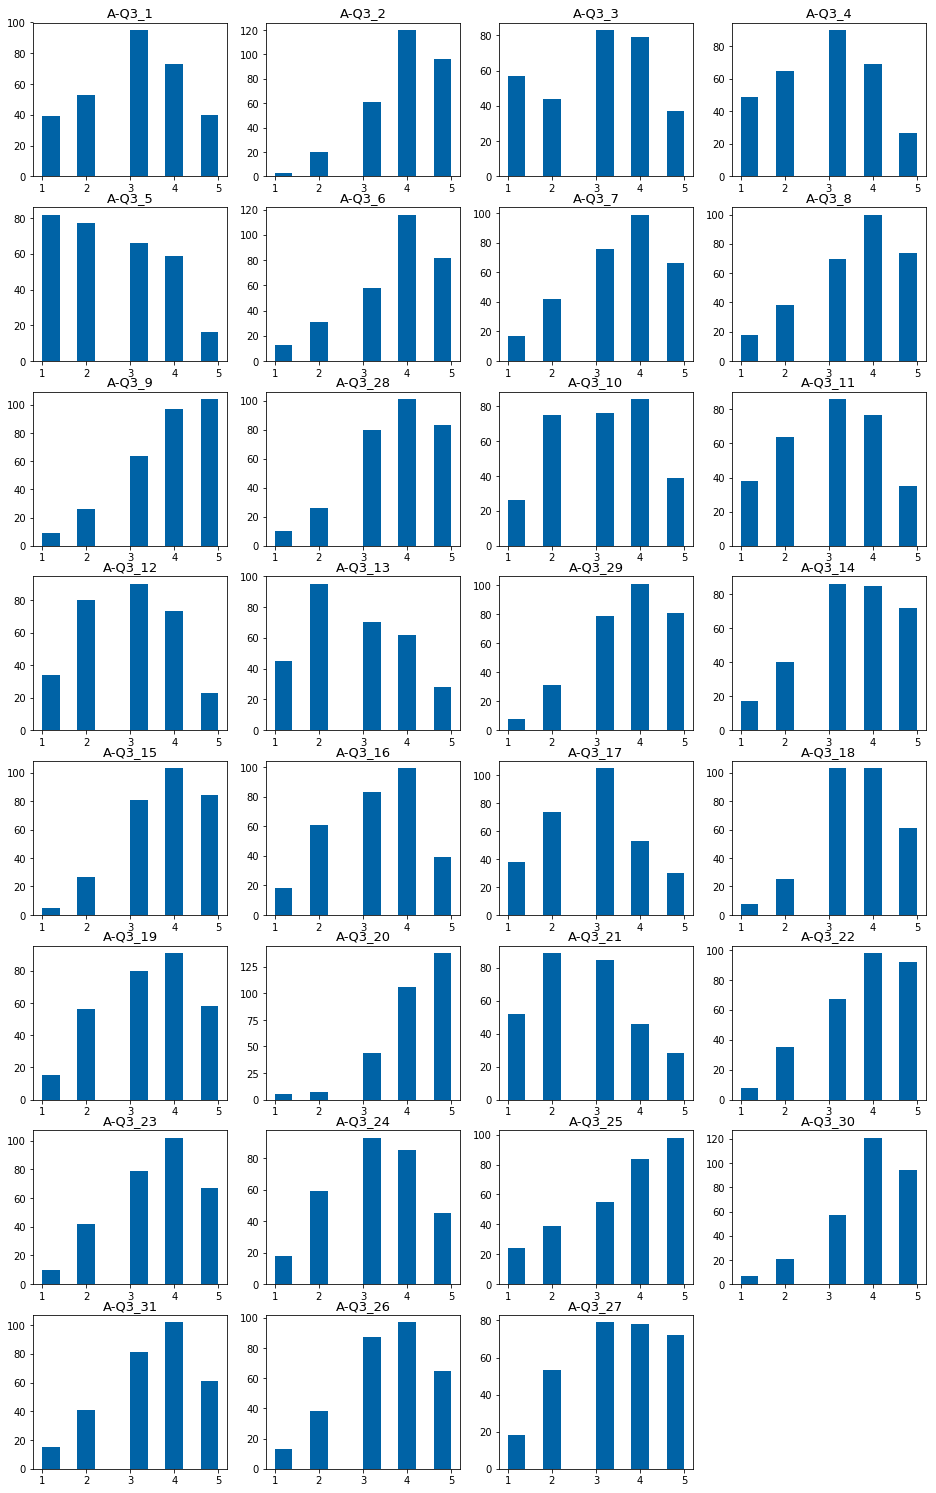

In [37]:
graf_hist(Daten_A3,Liste_A_Q3,16,30,9,4)

In [38]:
Daten_A3[Liste_A_Q3].mean().sort_values(ascending = False)

A-Q3_20    4.216667
A-Q3_2     3.953333
A-Q3_30    3.913333
A-Q3_9     3.870000
A-Q3_15    3.780000
A-Q3_22    3.770000
A-Q3_6     3.743333
A-Q3_28    3.736667
A-Q3_29    3.720000
A-Q3_25    3.643333
A-Q3_18    3.613333
A-Q3_23    3.580000
A-Q3_8     3.580000
A-Q3_26    3.543333
A-Q3_7     3.516667
A-Q3_14    3.516667
A-Q3_31    3.510000
A-Q3_27    3.443333
A-Q3_19    3.403333
A-Q3_16    3.266667
A-Q3_24    3.266667
A-Q3_10    3.116667
A-Q3_1     3.073333
A-Q3_11    3.023333
A-Q3_3     2.983333
A-Q3_12    2.903333
A-Q3_17    2.876667
A-Q3_4     2.866667
A-Q3_13    2.776667
A-Q3_21    2.696667
A-Q3_5     2.500000
dtype: float64

In [39]:
get_name_glossind('A-Q3_20')

(47, 'A-Q3 - Utilizo el sentido común y mis conocimientos generales.')

In [40]:
Daten_A3[Liste_A_Q3].std().sort_values()

A-Q3_20    0.897631
A-Q3_2     0.938487
A-Q3_18    0.986780
A-Q3_30    0.994545
A-Q3_15    1.007464
A-Q3_29    1.054501
A-Q3_28    1.060379
A-Q3_9     1.078724
A-Q3_23    1.083596
A-Q3_22    1.089828
A-Q3_26    1.094890
A-Q3_6     1.099158
A-Q3_16    1.107389
A-Q3_31    1.110862
A-Q3_24    1.119404
A-Q3_12    1.124665
A-Q3_19    1.142368
A-Q3_7     1.146343
A-Q3_17    1.148558
A-Q3_14    1.157954
A-Q3_8     1.163951
A-Q3_10    1.177999
A-Q3_21    1.195584
A-Q3_27    1.202056
A-Q3_4     1.202932
A-Q3_11    1.203168
A-Q3_13    1.204835
A-Q3_1     1.213617
A-Q3_5     1.230874
A-Q3_25    1.276016
A-Q3_3     1.291750
dtype: float64

Korrelation in A-Q3:

In [41]:
Korr_A_Q3 = Daten[Liste_A_Q3].corr(method = 'spearman')
Korr_A_Q3

,A-Q3_1,A-Q3_2,A-Q3_3,A-Q3_4,A-Q3_5,A-Q3_6,A-Q3_7,A-Q3_8,A-Q3_9,A-Q3_28,...,A-Q3_20,A-Q3_21,A-Q3_22,A-Q3_23,A-Q3_24,A-Q3_25,A-Q3_30,A-Q3_31,A-Q3_26,A-Q3_27
A-Q3_1,1.000000,0.357553,0.291868,0.172885,0.225569,0.023251,-0.016825,-0.000882,-0.017741,0.069743,...,0.142571,0.025817,0.045151,0.019735,0.041916,-0.021745,0.038881,0.086870,0.112402,0.024440
A-Q3_2,0.357553,1.000000,0.396476,0.288819,0.279599,0.178014,0.121506,0.070285,0.127024,0.174471,...,0.215636,-0.031629,0.103122,0.073171,0.160499,0.029154,0.183555,0.071202,0.212786,0.117747
A-Q3_3,0.291868,0.396476,1.000000,0.257619,0.247308,0.075639,0.039432,0.022347,0.042917,0.140144,...,0.123009,0.086699,0.111983,0.050676,0.186951,0.055161,0.061233,0.156535,0.170856,0.148300
A-Q3_4,0.172885,0.288819,0.257619,1.000000,0.298090,0.045292,0.036043,-0.036058,0.048596,0.095621,...,0.065620,0.176829,0.180900,0.128523,0.128895,0.095209,0.129381,0.081840,0.108601,0.183761
A-Q3_5,0.225569,0.279599,0.247308,0.298090,1.000000,0.275893,0.216315,0.174144,0.186116,0.151106,...,0.150077,0.229452,0.139250,0.173750,0.179840,0.124844,0.095624,0.177069,0.233599,0.221648
A-Q3_6,0.023251,0.178014,0.075639,0.045292,0.275893,1.000000,0.751294,0.652305,0.480994,0.259175,...,0.302094,0.108778,0.102785,0.157296,0.170142,0.074010,0.221181,0.063626,0.229312,0.207146
A-Q3_7,-0.016825,0.121506,0.039432,0.036043,0.216315,0.751294,1.000000,0.730273,0.479557,0.251117,...,0.322451,0.136351,0.117612,0.158131,0.160571,0.120226,0.235766,0.141976,0.251914,0.197192
A-Q3_8,-0.000882,0.070285,0.022347,-0.036058,0.174144,0.652305,0.730273,1.000000,0.596137,0.272614,...,0.331465,0.187987,0.136888,0.183288,0.213335,0.129416,0.238670,0.117627,0.219000,0.234366
A-Q3_9,-0.017741,0.127024,0.042917,0.048596,0.186116,0.480994,0.479557,0.596137,1.000000,0.316212,...,0.303081,0.159486,0.085078,0.186260,0.187388,0.101801,0.251411,0.177669,0.212490,0.271956
A-Q3_28,0.069743,0.174471,0.140144,0.095621,0.151106,0.259175,0.251117,0.272614,0.316212,1.000000,...,0.340431,0.032734,0.210102,0.240450,0.187554,0.066112,0.215293,0.284998,0.344093,0.182695


In [42]:
for col in Liste_A_Q3:
    print(get_max_corr(Korr_A_Q3,col,0.6))

Series([], Name: A-Q3_1, dtype: float64)
Series([], Name: A-Q3_2, dtype: float64)
Series([], Name: A-Q3_3, dtype: float64)
Series([], Name: A-Q3_4, dtype: float64)
Series([], Name: A-Q3_5, dtype: float64)
A-Q3_7    0.751294
A-Q3_8    0.652305
Name: A-Q3_6, dtype: float64
A-Q3_6    0.751294
A-Q3_8    0.730273
Name: A-Q3_7, dtype: float64
A-Q3_6    0.652305
A-Q3_7    0.730273
Name: A-Q3_8, dtype: float64
Series([], Name: A-Q3_9, dtype: float64)
Series([], Name: A-Q3_28, dtype: float64)
Series([], Name: A-Q3_10, dtype: float64)
A-Q3_12    0.611488
Name: A-Q3_11, dtype: float64
A-Q3_11    0.611488
Name: A-Q3_12, dtype: float64
Series([], Name: A-Q3_13, dtype: float64)
Series([], Name: A-Q3_29, dtype: float64)
Series([], Name: A-Q3_14, dtype: float64)
Series([], Name: A-Q3_15, dtype: float64)
Series([], Name: A-Q3_16, dtype: float64)
Series([], Name: A-Q3_17, dtype: float64)
Series([], Name: A-Q3_18, dtype: float64)
Series([], Name: A-Q3_19, dtype: float64)
Series([], Name: A-Q3_20, dtype: 

In [43]:
get_name_glossind('A-Q3_23')

(50, 'A-Q3 - Me fijo en cifras o en otros símbolos que entiendo.')

##### Gruppierung der Strategien nach Kategorien:

In [44]:
strat = {'S1': ['A-Q3_5','A-Q3_6','A-Q3_7','A-Q3_8','A-Q3_9'], 
         'S2': ['A-Q3_1','A-Q3_2','A-Q3_3','A-Q3_4','A-Q3_5'],
         'S3': ['A-Q3_9','A-Q3_10','A-Q3_11','A-Q3_12'],
         'S4': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16','A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S4a': ['A-Q3_13','A-Q3_14','A-Q3_15','A-Q3_16'],
         'S4b': ['A-Q3_17','A-Q3_18','A-Q3_19','A-Q3_20'],
         'S5': ['A-Q3_21','A-Q3_22','A-Q3_23','A-Q3_24','A-Q3_25'],
         'S6': ['A-Q3_26','A-Q3_27','A-Q3_28','A-Q3_29','A-Q3_30','A-Q3_31']}

* S1: Auf Wortebene - intralingual
* S2: Auf Wortebene - interlingual
* S3: Auf Satz- und Textebene - engerer Kontext
* S4: Auf Satz- und Textebene - weiterer Kontext (S4a: intratextuell, S4b: Bezug zu Fach- und Weltwissen)
* S5: Außersprachlicher Kontext
* S6: Metakognitive Strategien

In [45]:
#Daten_A3.loc[56, strat['S1']]

In [46]:
#Berechnung der Summe der Werte, des Mittelwerts und der Anzahl an Items mit einem bestimmten Wert (individuell):
#Daten.loc[56, strat['S1']].sum()
#Daten.loc[56, strat['S1']].mean()
#(Daten.loc[56, strat['S1']] >= 5).sum()

In [47]:
#Anzahl der TN, die einen Mittelwert >= 3 in der Strategiengruppe S1 aufweisen:
#Daten[Daten[strat['S1']].mean(axis=1) >= 3]

In [48]:
#Anzahl de#Anzahl der TN, die einen Mittelwert >= 3 in der Strategiengruppe S1 aufweisen:r TN, deren Summe der Werte in S1 >= 8 ist:
#Daten[Daten[strat['S1']].sum(axis=1) >= 8].shape[0]

##### Bandbreite und Frequenz der Strategiennutzung:

In der Folge wird berechnet, wie viele TN pro Strategiengruppe mit ihren Angaben einen Durchschnittswert von 3 (Likert) aufweisen und eine Mindestanzahl an Einzelstrategien pro Gruppe mit 3 bewertet haben.

In [49]:
Daten_A3[(Daten_A3[strat['S1']].mean(axis=1) >= 3) & ((Daten_A3[strat['S1']] >= 3).sum(axis=1) >= 2)].shape[0]

227

In [50]:
Daten_A3[(Daten_A3[strat['S2']].mean(axis=1) >= 3) & ((Daten_A3[strat['S2']] >= 3).sum(axis=1) >= 2)].shape[0]

177

In [51]:
Daten_A3[(Daten_A3[strat['S3']].mean(axis=1) >= 3) & ((Daten_A3[strat['S3']] >= 3).sum(axis=1) >= 2)].shape[0]

195

In [52]:
Daten_A3[(Daten_A3[strat['S4']].mean(axis=1) >= 3) & ((Daten_A3[strat['S4']] >= 3).sum(axis=1) >= 4)].shape[0]

230

In [53]:
Daten_A3[(Daten_A3[strat['S4a']].mean(axis=1) >= 3) & ((Daten_A3[strat['S4a']] >= 3).sum(axis=1) >= 2)].shape[0]

213

In [54]:
Daten_A3[(Daten_A3[strat['S4b']].mean(axis=1) >= 3) & ((Daten_A3[strat['S4b']] >= 3).sum(axis=1) >= 2)].shape[0]

238

In [55]:
Daten_A3[(Daten_A3[strat['S5']].mean(axis=1) >= 3) & ((Daten_A3[strat['S5']] >= 3).sum(axis=1) >= 2)].shape[0]

228

In [56]:
Daten_A3[(Daten_A3[strat['S6']].mean(axis=1) >= 3) & ((Daten_A3[strat['S6']] >= 3).sum(axis=1) >= 3)].shape[0]

260

Anzahl der TN, die in jeder Strategiengruppe einen Durchschnittswert von mindestens 2 (Likert) aufweisen und eine Mindestanzahl an Strategien mit 3 bewertet haben:

In [57]:
Daten_A3[(Daten_A3[strat['S1']].mean(axis=1) >= 2) & ((Daten_A3[strat['S1']] >= 3).sum(axis=1) >= 2) & (Daten_A3[strat['S2']].mean(axis=1) >= 2) & ((Daten_A3[strat['S2']] >= 3).sum(axis=1) >= 2) & (Daten_A3[strat['S3']].mean(axis=1) >= 2) & ((Daten_A3[strat['S3']] >= 3).sum(axis=1) >= 2) & (Daten_A3[strat['S4']].mean(axis=1) >= 2) & ((Daten_A3[strat['S4']] >= 3).sum(axis=1) >= 4) & (Daten_A3[strat['S5']].mean(axis=1) >= 2) & ((Daten_A3[strat['S5']] >= 3).sum(axis=1) >= 2) & (Daten_A3[strat['S6']].mean(axis=1) >= 2) & ((Daten_A3[strat['S6']] >= 3).sum(axis=1) >= 3)].shape[0]

183

Anzahl und Prozentsatz der TN, die eine Mindestanzahl an Strategien aus jeder Strategiengruppe mit 3 (Likert) bewertet haben:

In [58]:
def get_good_str(df):
    df_good = df[((df[strat['S1']] >= 3).sum(axis=1) >= 2) & ((df[strat['S2']] >= 3).sum(axis=1) >= 2) & ((df[strat['S3']] >= 3).sum(axis=1) >= 2) & ((df[strat['S4']] >= 3).sum(axis=1) >= 4) & ((df[strat['S5']] >= 3).sum(axis=1) >= 2) & ((df[strat['S6']] >= 3).sum(axis=1) >= 3)]
    return df_good.shape[0], (df_good.shape[0])/(df.shape[0])*100

In [59]:
get_good_str(Daten_A3)

(187, 62.33333333333333)

### Erwerb von Erschließungsstrategien

#### B-Q1 (Kontexte des Strategienerwerbs)

In [64]:
Kontexte = Finished[['B-Q1_1','B-Q1_2','B-Q1_3','B-Q1_4','B-Q1_5','B-Q1_6','B-Q1_7','B-Q1_8','B-Q1_9','B-Q1_10','B-Q1_11']]

In [65]:
DF_Kontexte = Kontexte.apply(pd.value_counts).fillna(0).astype(integer)

In [66]:
DF_Kontexte.iloc[1].sort_values(ascending = False)

B-Q1_7     181
B-Q1_2     169
B-Q1_9     166
B-Q1_3     135
B-Q1_6     115
B-Q1_1     107
B-Q1_5     102
B-Q1_4      89
B-Q1_8      70
B-Q1_10     15
B-Q1_11      8
Name: 1, dtype: int32

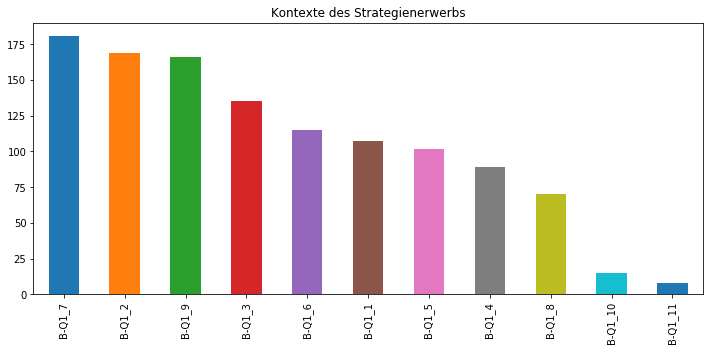

In [67]:
DF_Kontexte.iloc[1].sort_values(ascending = False).plot(kind='bar', 
                                                            figsize = (12,5), width = 0.5, 
                                                            legend = False, title = "Kontexte des Strategienerwerbs");

* 1- En las clases de Lengua y Literatura en el colegio o instituto
* 2- En las clases de inglés en el colegio o instituto
* 3- En otras clases de idiomas en el colegio o instituto
* 4- En clases de alemán anteriores en la Universidad
* 5- En otras asignaturas de mi carrera universitaria
* 6- En clases de lenguas en escuelas de idiomas o academias
* 7- En mi curso de alemán actual
* 8- En mi familia, con mis amigos/as o compañeros/as de clase
* 9- Por mi cuenta, sin ayuda de otras personas
* 10- Otros:
* 11- No sé cómo he aprendido estas estrategias.

#### B-Q2 (Methoden des Strategienerwerbs)

Erwerbskontexte:

In [68]:
erwerb = {'E1': ['B-Q2-1_1','B-Q2-1_2','B-Q2-1_3','B-Q2-1_4','B-Q2-1_5','B-Q2-1_6','B-Q2-1_7'], 
         'E2': ['B-Q2-2_1','B-Q2-2_2','B-Q2-2_3','B-Q2-2_4','B-Q2-2_5','B-Q2-2_6','B-Q2-2_7'],
         'E3': ['B-Q2-3_1','B-Q2-3_2','B-Q2-3_3','B-Q2-3_4','B-Q2-3_5','B-Q2-3_6','B-Q2-3_7'],
         'E4': ['B-Q2-4_1','B-Q2-4_2','B-Q2-4_3','B-Q2-4_4','B-Q2-4_5','B-Q2-4_6','B-Q2-4_7'],
         'E5': ['B-Q2-5_1','B-Q2-5_2','B-Q2-5_3','B-Q2-5_4','B-Q2-5_5','B-Q2-5_6','B-Q2-5_7'],
         'E6': ['B-Q2-6_1','B-Q2-6_2','B-Q2-6_3','B-Q2-6_4','B-Q2-6_5','B-Q2-6_6','B-Q2-6_7'],
         'E7': ['B-Q2-7_1','B-Q2-7_2','B-Q2-7_3','B-Q2-7_4','B-Q2-7_5','B-Q2-7_6','B-Q2-7_7'],
         'E8': ['B-Q2-8_1','B-Q2-8_2','B-Q2-8_3','B-Q2-8_4','B-Q2-8_5'],
         'E9': ['B-Q2-9_1','B-Q2-9_2','B-Q2-9_3','B-Q2-9_4','B-Q2-9_5']}

Methoden des Stragienerwerbs (kontextübergreifend in Unterrichtssituationen):

In [69]:
erwerb1 = {'U1': ['B-Q2-1_1','B-Q2-2_1','B-Q2-3_1','B-Q2-4_1','B-Q2-5_1','B-Q2-6_1','B-Q2-7_1'], 
         'U2': ['B-Q2-1_2','B-Q2-2_2','B-Q2-3_2','B-Q2-4_2','B-Q2-5_2','B-Q2-6_2','B-Q2-7_2'],
         'U3': ['B-Q2-1_3','B-Q2-2_3','B-Q2-3_3','B-Q2-4_3','B-Q2-5_3','B-Q2-6_3','B-Q2-7_3'],
         'U4': ['B-Q2-1_4','B-Q2-2_4','B-Q2-3_4','B-Q2-4_4','B-Q2-5_4','B-Q2-6_4','B-Q2-7_4'],
         'U5': ['B-Q2-1_5','B-Q2-2_5','B-Q2-3_5','B-Q2-4_5','B-Q2-5_5','B-Q2-6_5','B-Q2-7_5'],
         'U6': ['B-Q2-1_6','B-Q2-2_6','B-Q2-3_6','B-Q2-4_6','B-Q2-5_6','B-Q2-6_6','B-Q2-7_6'],
         'U7': ['B-Q2-1_7','B-Q2-2_7','B-Q2-3_7','B-Q2-4_7','B-Q2-5_7','B-Q2-6_7','B-Q2-7_7']}

Auswahl der TN, die mindestens einmal eine bestimmte Methode angegeben haben:

In [70]:
Stud_U1 = Finished[(Finished['B-Q2-1_1'] == 1) | (Finished['B-Q2-2_1'] == 1) | (Finished['B-Q2-3_1'] == 1) | (Finished['B-Q2-4_1'] == 1 | (Finished['B-Q2-5_1'] == 1 | (Finished['B-Q2-6_1'] == 1) | (Finished['B-Q2-7_1'] == 1)))]
Stud_U2 = Finished[(Finished['B-Q2-1_2'] == 1) | (Finished['B-Q2-2_2'] == 1) | (Finished['B-Q2-3_2'] == 1) | (Finished['B-Q2-4_2'] == 1 | (Finished['B-Q2-5_2'] == 1 | (Finished['B-Q2-6_2'] == 1) | (Finished['B-Q2-7_2'] == 1)))]
Stud_U3 = Finished[(Finished['B-Q2-1_3'] == 1) | (Finished['B-Q2-2_3'] == 1) | (Finished['B-Q2-3_3'] == 1) | (Finished['B-Q2-4_3'] == 1 | (Finished['B-Q2-5_3'] == 1 | (Finished['B-Q2-6_3'] == 1) | (Finished['B-Q2-7_3'] == 1)))]
Stud_U4 = Finished[(Finished['B-Q2-1_4'] == 1) | (Finished['B-Q2-2_4'] == 1) | (Finished['B-Q2-3_4'] == 1) | (Finished['B-Q2-4_4'] == 1 | (Finished['B-Q2-5_4'] == 1 | (Finished['B-Q2-6_4'] == 1) | (Finished['B-Q2-7_4'] == 1)))]
Stud_U5 = Finished[(Finished['B-Q2-1_5'] == 1) | (Finished['B-Q2-2_5'] == 1) | (Finished['B-Q2-3_5'] == 1) | (Finished['B-Q2-4_5'] == 1 | (Finished['B-Q2-5_5'] == 1 | (Finished['B-Q2-6_5'] == 1) | (Finished['B-Q2-7_5'] == 1)))]
Stud_U6 = Finished[(Finished['B-Q2-1_6'] == 1) | (Finished['B-Q2-2_6'] == 1) | (Finished['B-Q2-3_6'] == 1) | (Finished['B-Q2-4_6'] == 1 | (Finished['B-Q2-5_6'] == 1 | (Finished['B-Q2-6_6'] == 1) | (Finished['B-Q2-7_6'] == 1)))]

In [71]:
Stud_U = []
Stud_U.append(Stud_U1.shape[0])
Stud_U.append(Stud_U2.shape[0])
Stud_U.append(Stud_U3.shape[0])
Stud_U.append(Stud_U4.shape[0])
Stud_U.append(Stud_U5.shape[0])
Stud_U.append(Stud_U6.shape[0])

In [179]:
Stud_U = pd.Series(Stud_U)
Stud_U.index += 1

In [183]:
Stud_E8 = Finished[(Finished['B-Q2-8_1'] == 1) | (Finished['B-Q2-8_2'] == 1) | (Finished['B-Q2-8_3'] == 1) | (Finished['B-Q2-8_4'] == 1 | (Finished['B-Q2-8_5'] == 1))]
Stud_E9 = Finished[(Finished['B-Q2-9_1'] == 1) | (Finished['B-Q2-9_2'] == 1) | (Finished['B-Q2-9_3'] == 1) | (Finished['B-Q2-9_4'] == 1 | (Finished['B-Q2-9_5'] == 1))]

##### Methoden des Strategienerwerbs nach Erwerbskontexten

In [73]:
Finished[erwerb['E1']].apply(sum).sort_values(ascending = False)

B-Q2-1_6    62
B-Q2-1_2    59
B-Q2-1_3    45
B-Q2-1_1    38
B-Q2-1_5    22
B-Q2-1_4    11
B-Q2-1_7     5
dtype: int64

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

In [74]:
Finished[Finished['B-Q2-1_7_TEXT'] != 0]['B-Q2-1_7_TEXT']

134                 Intuición y devoción por las lenguas
199    las he aprendido por los profesores [comentari...
204                                         por mi parte
275    tambien al traducir latín y griego clásico al ...
290    Gran parte fue gracias a dos buenos profesores...
Name: B-Q2-1_7_TEXT, dtype: object

In [75]:
DF_Erwerb = pd.DataFrame(np.nan, columns=list(erwerb.keys())[:7], index = [1,2,3,4,5,6,7])

In [76]:
for key in list(erwerb.keys())[:7]:
    DF_Erwerb[key] = Finished[erwerb[key]].sum().values

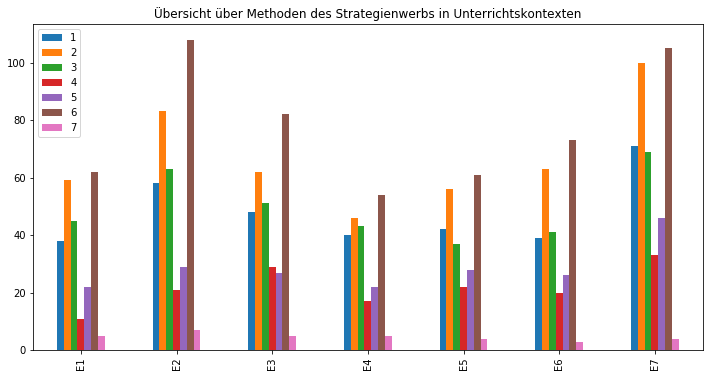

In [79]:
DF_Erwerb.T.plot(kind = 'bar', figsize = (12,6), title = 'Übersicht über Methoden des Strategienwerbs in Unterrichtskontexten');

In [80]:
Finished[erwerb['E8']].apply(sum).sort_values(ascending = False)

B-Q2-8_3    51
B-Q2-8_2    30
B-Q2-8_4    29
B-Q2-8_1    18
B-Q2-8_5     3
dtype: int64

* (1)	He conocido estas estrategias en mi familia.
* (2)	He conocido estas estrategias hablando con amigos/as y conocidos/as.
* (3)	He conocido estas estrategias hablando con compañeros/as de clase.
* (4)	He conocido estas estrategias imitando hábitos de trabajo de compañeros/as de clase aventajados/as.
* (5)	Otros:

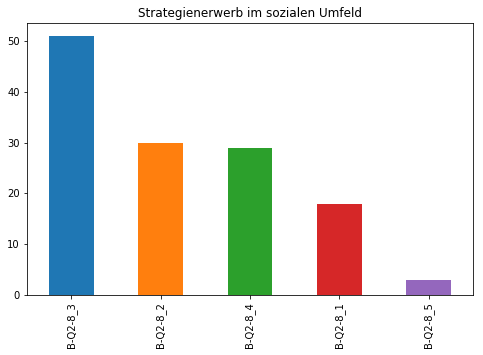

In [81]:
Finished[erwerb['E8']].apply(sum).sort_values(ascending = False).plot(kind='bar', 
                                                                    figsize = (8,5), width = 0.5, 
                                                                    legend = False, title = "Strategienerwerb im sozialen Umfeld");

In [82]:
Finished[erwerb['E9']].apply(sum).sort_values(ascending = False)

B-Q2-9_1    131
B-Q2-9_2    115
B-Q2-9_3     39
B-Q2-9_4     37
B-Q2-9_5      9
dtype: int64

* (1)	He desarrollado estas estrategias por mi cuenta durante el aprendizaje y el uso de idiomas, p. ej. leyendo textos difíciles.
* (2)	He probado diferentes cosas y me he dado cuenta de qué funciona mejor para mi.
* (3)	He aprendido estas estrategias con ayuda de páginas web o blogs.
* (4)	He aprendido estas estrategias con ayuda de libros.
* (5)	He aprendido estas estrategias con ayuda de otros materiales. (Opcional: Cuáles?)

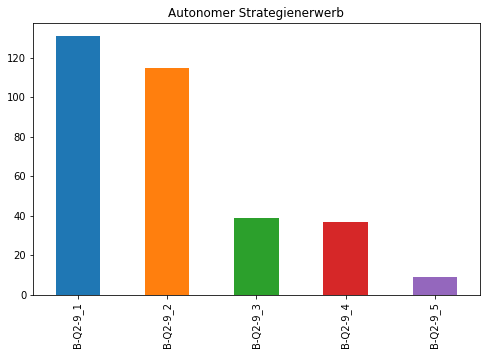

In [83]:
Finished[erwerb['E9']].apply(sum).sort_values(ascending = False).plot(kind='bar', 
                                                                    figsize = (8,5), width = 0.5, 
                                                                    legend = False, title = "Autonomer Strategienerwerb");

##### Übersicht über Methoden des Strategienerwerbs in Unterrichtskontexten

In [84]:
Finished[erwerb1['U1']].apply(pd.value_counts).astype(integer).iloc[1].sum()

336

In [85]:
Erwerb_U = []
for lst in erwerb1:
        Erwerb_U.append(Finished[erwerb1[lst]].apply(pd.value_counts).astype(integer).iloc[1].sum())

In [86]:
Erwerb_U

[336, 469, 349, 153, 200, 545, 33]

In [87]:
Erwerb_U = pd.Series(Erwerb_U)

In [175]:
Erwerb_U.index += 1

In [176]:
Erwerb_U.sort_values(ascending = False)

6    545
2    469
3    349
1    336
5    200
4    153
7     33
dtype: int64

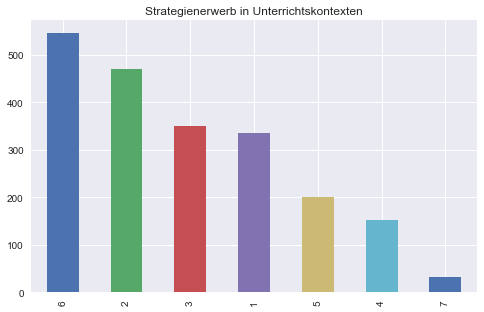

In [268]:
Erwerb_U.sort_values(ascending = False).plot(kind='bar', 
                                        figsize = (8,5), width = 0.5, 
                                        legend = False, title = "Strategienerwerb in Unterrichtskontexten");

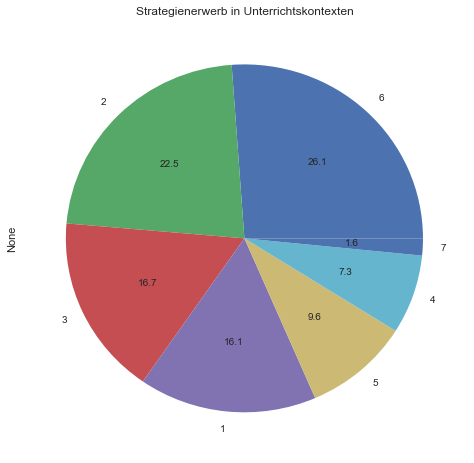

In [267]:
Erwerb_U.sort_values(ascending = False).plot(kind='pie', 
                                        figsize = (8,8), autopct='%.1f',
                                        legend = False, title = "Strategienerwerb in Unterrichtskontexten");

* (1)	Las estrategias se presentaron (y explicaron) en clase.
* (2)	El/La profesor/a dio consejos sobre cómo familiarizarse de manera autónoma con estas estrategias, p. ej. mediante páginas web, libros u otros materiales que explican estrategias de aprendizaje. 
* (3)	Estas estrategias se explicaron y practicaron con ejemplos concretos, realizando tareas, p. ej. leyendo un texto difícil.
* (4)	Se probaron y se compararon diferentes estrategias.
* (5)	Se reflexionó sobre el uso de estas estrategias, p. ej. sobre qué estrategia sería adecuada en una situación y/o para una persona determinada.
* (6)	Durante las clases he aprendido estas estrategias de manera inconsciente, p. ej. mientras leía textos difíciles, sin explicación o indicación del/de la profesor/a.
* (7)	Otros:

##### Untersuchung der Relation zwischen Strategienerwerb und -anwendung

In [180]:
Stud_U.sort_values(ascending=False)

6    162
2    141
3    105
1    102
5     63
4     50
dtype: int64

In [181]:
get_good_str(Stud_U1)

(70, 68.62745098039215)

In [93]:
get_good_str(Stud_U2)

(99, 70.2127659574468)

In [94]:
get_good_str(Stud_U3)

(74, 70.47619047619048)

In [95]:
get_good_str(Stud_U4)

(35, 70.0)

In [96]:
get_good_str(Stud_U5)

(47, 74.60317460317461)

In [97]:
get_good_str(Stud_U6)

(105, 64.81481481481481)

In [184]:
get_good_str(Stud_E8)

(47, 70.1492537313433)

In [185]:
get_good_str(Stud_E9)

(104, 62.65060240963856)

#### B-Q3 + B-Q4 (Strategienwerb im Rahmen der Befragung)

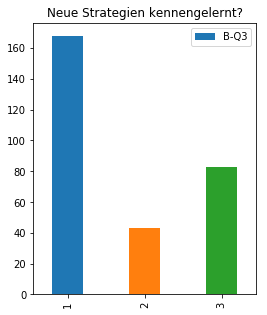

In [98]:
Finished['B-Q3'].value_counts()[[1,2,3]].plot(kind = 'bar', figsize = (4,5), width = 0.4, legend = True, title = "Neue Strategien kennengelernt?");

(1) Ja
(2) Nein
(3) Vielleicht

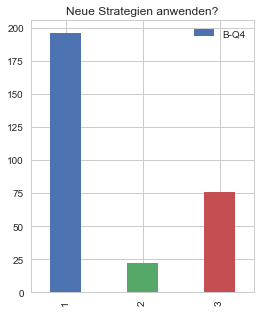

In [296]:
Finished['B-Q4'].value_counts()[[1,2,3]].plot(kind = 'bar', figsize = (4,5), width = 0.4, legend = True, title = "Neue Strategien anwenden?");

### Einstellung zu Erschließungsstrategien

#### C-Q1

In [100]:
Finished[Liste_C_Q1].describe()

,C-Q1_1,C-Q1_2,C-Q1_3,C-Q1_4,C-Q1_5,C-Q1_6,C-Q1_7
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,3.448980,3.612245,3.744898,4.394558,4.391156,4.299320,2.554422
std,0.891244,1.108139,1.105165,0.830788,0.788174,0.845909,1.178055
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,2.000000
50%,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,2.000000
75%,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


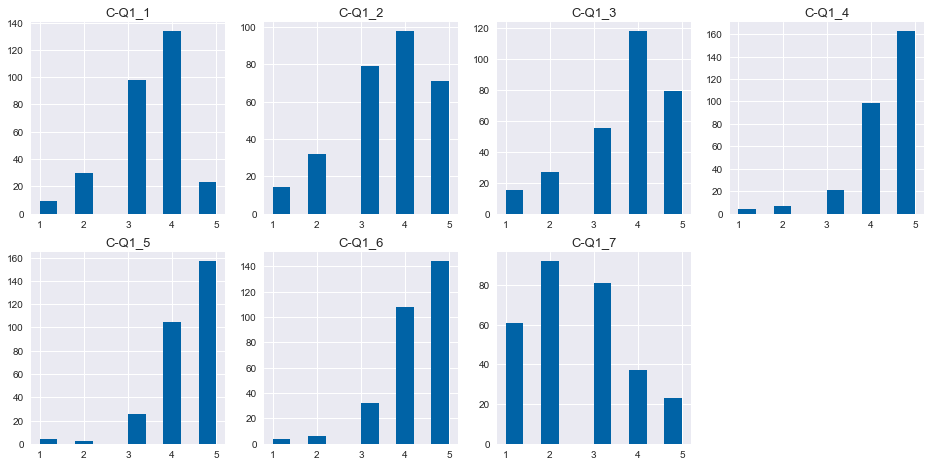

In [265]:
graf_hist(Finished,Liste_C_Q1,16,12,3,4)

1
Pienso que en alemán utilizo estas estrategias con éxito. 

2
Estas estrategias son un tema importante en mis clases de alemán.

3
Utilizo estas estrategias a menudo fuera del aula, p. ej. cuando leo textos en alemán en mi tiempo libre.

4
Estas estrategias son útiles para ampliar el vocabulario en alemán.

5
Estas estrategias son útiles para entender mejor textos en alemán.

6
Estas estrategias deberían explicarse y practicarse en las clases de alemán.

7
No hace falta aprender estas estrategias, ya que las usamos en cualquier caso de forma inconsciente. 


Korrelation in C-Q1:

In [102]:
Korr_C_Q1 = Daten[Liste_C_Q1].corr(method = 'spearman')
Korr_C_Q1

,C-Q1_1,C-Q1_2,C-Q1_3,C-Q1_4,C-Q1_5,C-Q1_6,C-Q1_7
C-Q1_1,1.000000,0.166330,0.460826,0.364827,0.381106,0.177434,0.160711
C-Q1_2,0.166330,1.000000,0.070945,0.269025,0.341017,0.300581,-0.005052
C-Q1_3,0.460826,0.070945,1.000000,0.258157,0.365397,0.121001,0.129022
C-Q1_4,0.364827,0.269025,0.258157,1.000000,0.585881,0.301667,-0.103350
C-Q1_5,0.381106,0.341017,0.365397,0.585881,1.000000,0.357846,-0.033119
C-Q1_6,0.177434,0.300581,0.121001,0.301667,0.357846,1.000000,-0.118782
C-Q1_7,0.160711,-0.005052,0.129022,-0.103350,-0.033119,-0.118782,1.000000


In [103]:
for col in Liste_C_Q1:
    print(get_max_corr(Korr_C_Q1,col,0.5))

Series([], Name: C-Q1_1, dtype: float64)
Series([], Name: C-Q1_2, dtype: float64)
Series([], Name: C-Q1_3, dtype: float64)
C-Q1_5    0.585881
Name: C-Q1_4, dtype: float64
C-Q1_4    0.585881
Name: C-Q1_5, dtype: float64
Series([], Name: C-Q1_6, dtype: float64)
Series([], Name: C-Q1_7, dtype: float64)


### Biplot?

In [257]:
Biplot_test = biplot.Classic(Finished[strat['S1']], 5, method = 1)

In [281]:
jahre = [el-1 for el in Finished['D-Q2b']]

In [283]:
Bip_can = biplot.Canonical(Finished[strat['S6']],dim=6,GroupNames=[0,1,2,3],y=jahre, method=1)

In [258]:
Biplot_test.Inert

array([58.89680987, 18.32608371, 11.89053677,  6.20945159,  4.67711806])

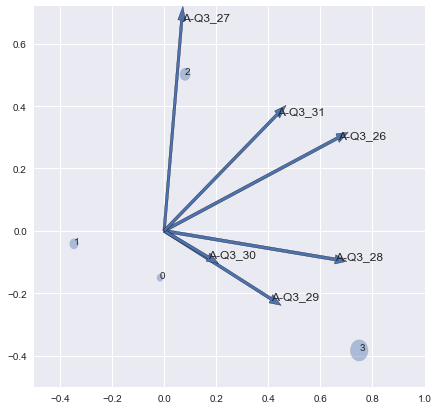

In [293]:
Bip_can.plot(xlim=[-0.5,1] , ylim=[-0.5,0.72], figx = 7, figy = 7, arrow_width = 0.01, font_size = 12, radius = 'Chis')

In [270]:
def graf_biplot(data, dim, dim1 = 0, dim2 = 1, sx = 10, sy = 10):
    
    B = biplot.Classic(data, dim, method = 1) 
    R = B.RowCoord
    C = B.ColCoord
    
    fig = plt.figure(figsize=(sx,sy))
    ax = fig.add_subplot(111)
    
    ax.scatter(R[:,dim1],R[:,dim2], s=9)
    #for i in range(R.shape[0]): # Könnte Text (hier Index) zu den Punkten anzeigen.
    #    ax.text(R[i,dim1],R[i,dim2], str(data.index[i]), fontsize=2)
    for i in range(C.shape[0]):
        ax.arrow(0,0,C[i,dim1],C[i,dim2], alpha = 0.7)
        #ax.scatter(C[i,dim1],C[i,dim2]) # Hier würden Linien nicht angezeigt.
        ax.text(C[i,dim1],C[i,dim2],data.columns[i], alpha = 0.7);

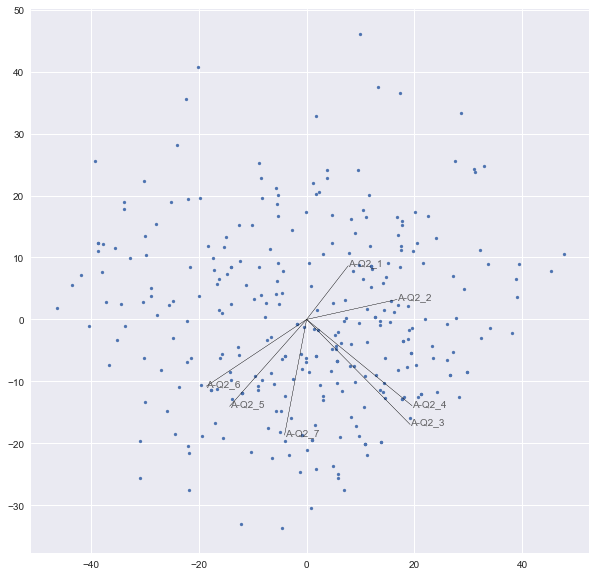

In [280]:
graf_biplot(Daten[Liste_A_Q2],7)

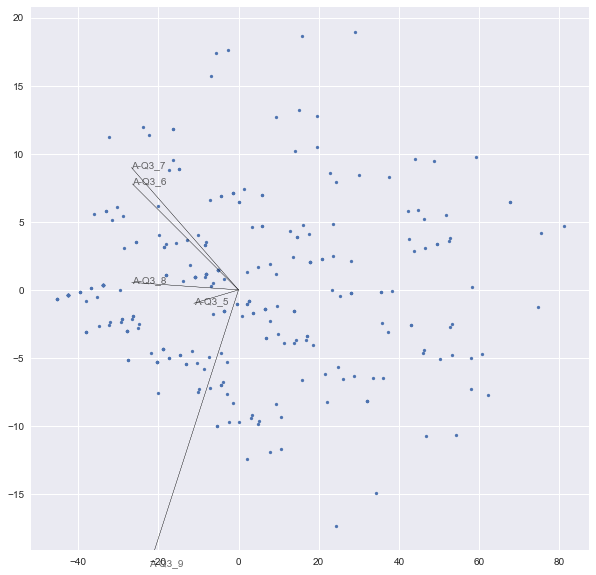

In [271]:
graf_biplot(Finished[strat['S1']],5, dim1=0, dim2=2)

In [274]:
Finished[strat['S1']].head()

,A-Q3_5,A-Q3_6,A-Q3_7,A-Q3_8,A-Q3_9
0,3,4,4,4,3
1,2,5,5,5,5
2,2,3,2,3,3
3,4,5,5,5,5
4,4,4,4,4,5


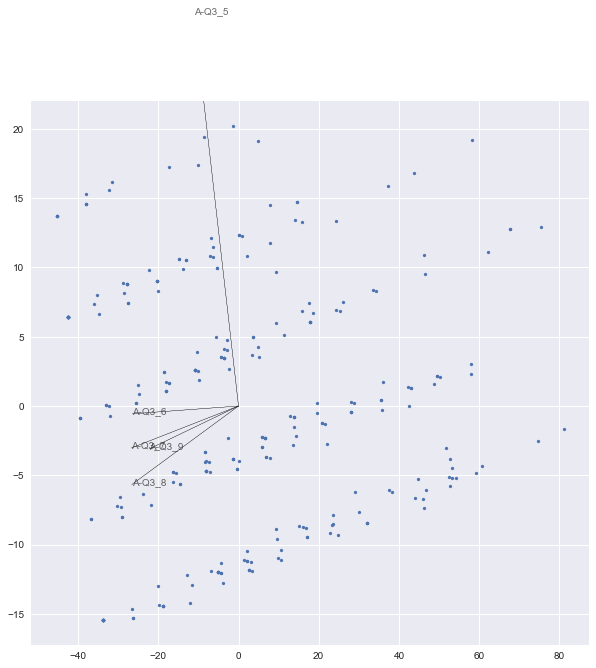

In [278]:
graf_biplot(Finished[strat['S1']],5)

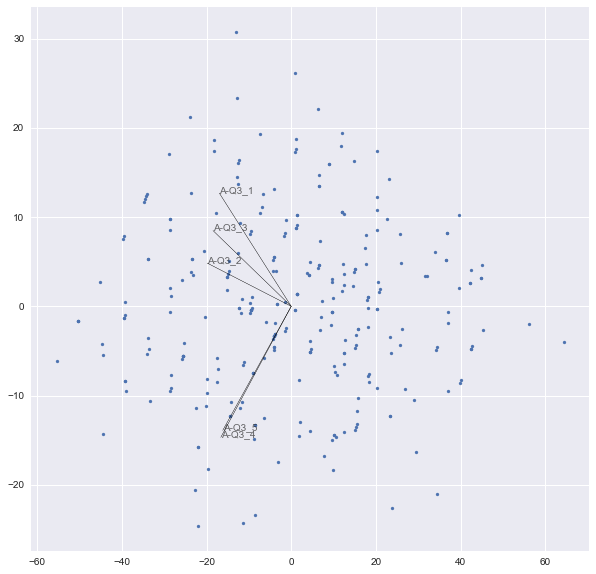

In [279]:
graf_biplot(Finished[strat['S2']],5)

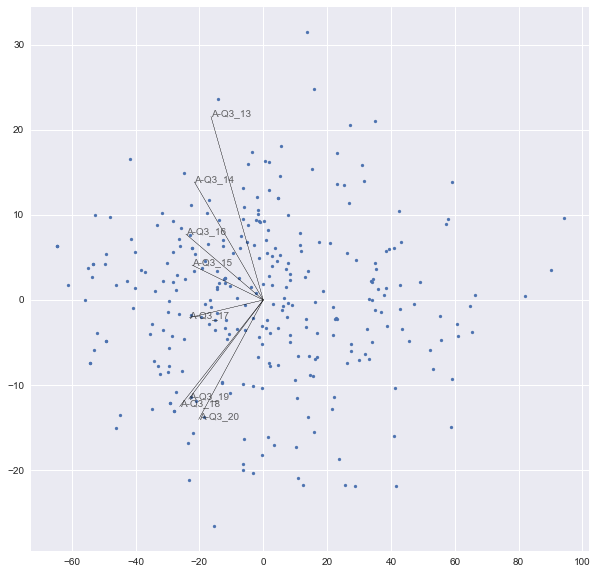

In [272]:
graf_biplot(Finished[strat['S4']],8)

### Charakteristika der Stichprobe

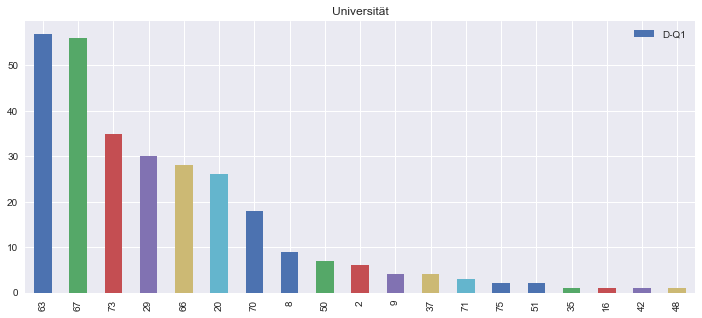

In [269]:
Finished[Finished['D-Q1'] != 0]['D-Q1'].value_counts().plot(kind='bar', 
                                                            figsize = (12,5), width = 0.5, 
                                                            legend = True, title = "Universität");

(1)	Abat Oliba-CEU
(2)	Alcalá de Henares
(3)	Alfonso X El Sabio
(4)	Alicante
(5)	Almería
(6)	Antonio de Nebrija
(7)	Autónoma de Barcelona
(8)	Autónoma de Madrid
(9)	Barcelona
(10)	Burgos
(11)	Cádiz
(12)	Camilo José Cela
(13)	Cantabria
(14)	Cardenal Herrera-CEU
(15)	Carlos III
(16)	Castilla-La Mancha
(17)	Católica de Ávila
(18)	Católica de Valencia
(19)	Católica S. Antonio de Murcia
(20)	Complutense de Madrid
(21)	Córdoba
(22)	Coruña, A
(23)	Deusto
(24)	Europea de Madrid
(25)	Europea Miguel de Cervantes
(26)	Extremadura
(27)	Francisco de Vitoria
(28)	Girona
(29)	Granada
(30)	Huelva
(31)	IE Universidad
(32)	Illes Balears
(33)	Internacional de Catalunya
(34)	Internacional de La Rioja
(35)	Internacional Valenciana
(36)	Jaén
(37)	Jaume I de Castellón
(38)	La Laguna
(39)	La Rioja
(40)	León
(41)	Lleida
(42)	Málaga
(43)	Miguel Hernández de Elche
(44)	Mondragón
(45)	Murcia
(46)	Navarra
(47)	Oberta de Catalunya
(48)	Oviedo
(49)	Pablo de Olavide
(50)	País Vasco
(51)	Palmas (Las)
(52)	Politécnica de Cartagena
(53)	Politécnica de Cataluña
(54)	Politécnica de Madrid
(55)	Politécnica de Valencia
(56)	Pompeu Fabra
(57)	Pontificia Comillas
(58)	Pontificia de Salamanca
(59)	Pública de Navarra
(60)	Ramón Llull
(61)	Rey Juan Carlos
(62)	Rovira i Virgili
(63)	Salamanca
(64)	San Jorge
(65)	San Pablo-CEU
(66)	Santiago de Compostela
(67)	Sevilla
(68)	U.N.E.D.
(69)	UDIMA
(70)	Valencia (Est. General)
(71)	Valladolid
(72)	Vic
(73)	Vigo
(74)	Zaragoza
(75)	Otra

In [105]:
Finished['D-Q1'].value_counts()

63    57
67    56
73    35
29    30
66    28
20    26
70    18
8      9
50     7
2      6
37     4
9      4
0      3
71     3
75     2
51     2
16     1
35     1
48     1
42     1
Name: D-Q1, dtype: int64

In [106]:
Finished['D-Q1'].nunique()

20

In [107]:
Finished['D-Q1a'].value_counts()

0                           292
Universidad Complutence       1
Universidad de Valencia       1
Name: D-Q1a, dtype: int64

Studierende aus 18 verschiedenen Universitäten nahmen an der Befragung teil.

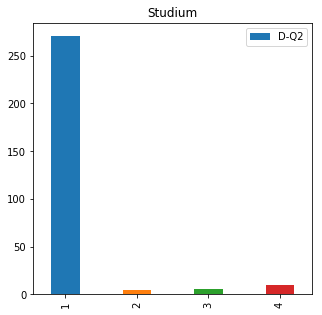

In [108]:
Finished['D-Q2'].value_counts()[[1,2,3,4]].plot(kind = 'bar', figsize = (5,5), width = 0.4, legend = True, title = "Studium");

(1)	Grado
(2)	Posgrado/Máster 
(3)	Doctorado
(4)	Otros

In [109]:
Finished['D-Q2'].value_counts()

1    271
4     10
3      6
2      5
0      2
Name: D-Q2, dtype: int64

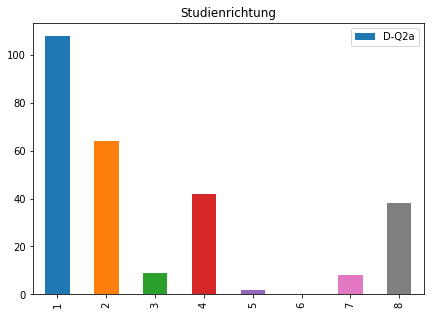

In [110]:
Finished['D-Q2a'].value_counts().reindex([1,2,3,4,5,6,7,8]).plot(kind='bar', figsize = (7,5), width = 0.5, legend = True, title = "Studienrichtung");

(1) Estudios Alemanes / Filología Alemana (Germanistikstudium / deutsche Philologie), (2) Otras Filologías (Anderes Philologiestudium), (3) Traducción, Alemán 1a Lengua Extranjera / B (Übersetzen und Dolmetschen, Erste Fremdsprache / Sprache B), (4) Traducción, Alemán 2a Lengua Extranjera / C (Übersetzen und Dolmetschen, Zweite Fremdsprache / Sprache C), (5) Humanidades (Humanistisches Studium), (6) Economía (Wirtschaftliches Studium), (7) Turismo (Tourismus-Studium), (8) Otra (Andere)

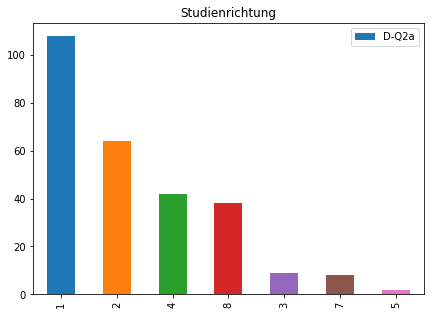

In [111]:
Finished[Finished['D-Q2a'] !=0]['D-Q2a'].value_counts().plot(kind='bar', figsize = (7,5), width = 0.5, legend = True, title = "Studienrichtung");

In [112]:
Finished['D-Q2a'].value_counts()

1    108
2     64
4     42
8     38
0     23
3      9
7      8
5      2
Name: D-Q2a, dtype: int64

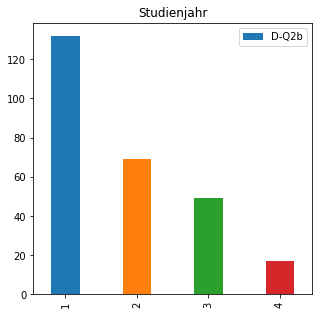

In [113]:
Finished['D-Q2b'].value_counts()[[1,2,3,4]].plot(kind='bar', figsize = (5,5), width = 0.4, legend = True, title = "Studienjahr");

In [114]:
Finished['D-Q2b'].value_counts()

1    132
2     69
3     49
0     27
4     17
Name: D-Q2b, dtype: int64

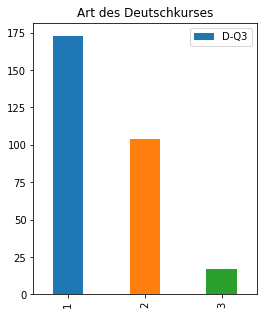

In [115]:
Finished['D-Q3'].value_counts()[[1,2,3]].plot(kind = 'bar', figsize = (4,5), width = 0.4, legend = True, title = "Art des Deutschkurses");

(1) Pflichtfach, (2) Wahlfach, (3) extracurricularer Kurs

In [116]:
Finished['D-Q3'].value_counts()

1    173
2    104
3     17
Name: D-Q3, dtype: int64

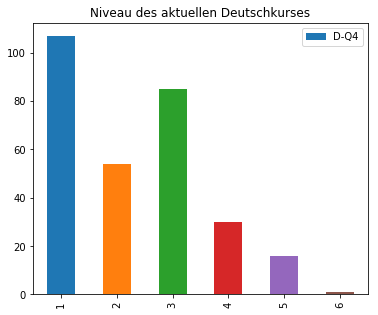

In [117]:
Finished['D-Q4'].value_counts()[[1,2,3,4,5,6]].plot(kind='bar', figsize = (6,5), width = 0.5, legend = True, title = "Niveau des aktuellen Deutschkurses");

(1)	A1, 
(2)	A2, 
(3)	B1, 
(4)	B2, 
(5)	C1,
(6)	C2 

In [118]:
Finished['D-Q4'].value_counts()

1    107
3     85
2     54
4     30
5     16
6      1
0      1
Name: D-Q4, dtype: int64

In [119]:
Finished[Finished['D-Q5'] != 0]['D-Q5'].describe()

count    285.000000
mean      21.449123
std        6.305741
min       17.000000
25%       18.000000
50%       20.000000
75%       21.000000
max       59.000000
Name: D-Q5, dtype: float64

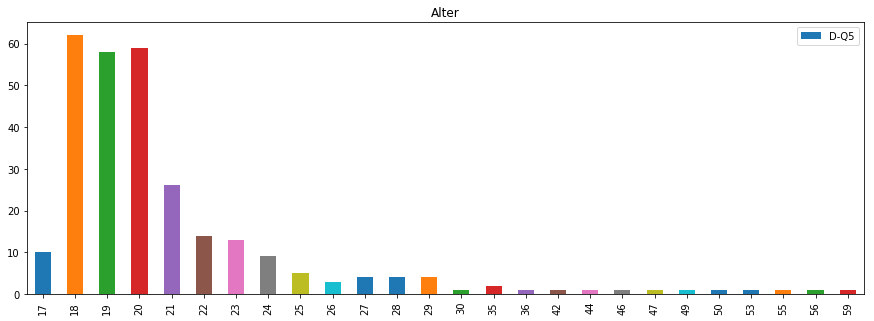

In [120]:
Finished[Finished['D-Q5'] != 0]['D-Q5'].astype(integer).value_counts().sort_index().plot(kind='bar', figsize = (15,5), legend = True, title = "Alter");

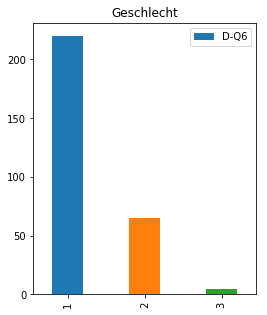

In [121]:
Finished['D-Q6'].value_counts()[[1,2,3]].plot(kind = 'bar', figsize = (4,5), width = 0.4, legend = True, title = "Geschlecht");

In [122]:
Finished['D-Q6'].value_counts()

1    220
2     65
3      5
0      4
Name: D-Q6, dtype: int64

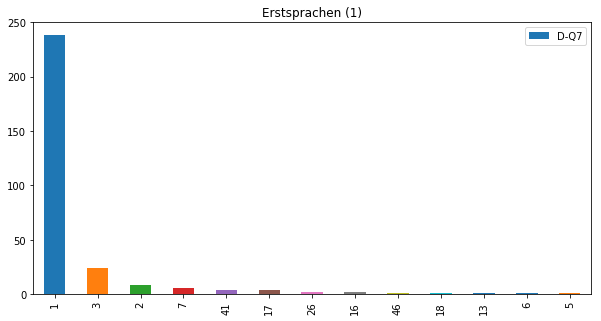

In [123]:
Finished[Finished['D-Q7'] != 0]['D-Q7'].value_counts().plot(kind='bar', figsize = (10,5), legend = True, title = "Erstsprachen (1)");

(1) 	Castellano
(2) 	Catalán (Català), Valenciano (Valencià)
(3) 	Gallego (Galego)
(4) 	Vasco (Euskara)
(5) 	Alemán (Deutsch)
(6) 	Árabe (العربية)
(7) 	Chino mandarín (中文)
(8) 	Coreano (한국어)
(9) 	Danés (Dansk)
(10) 	Francés (Français)
(11) 	Griego moderno (Ελληνικά)
(12) 	Inglés (English)
(13) 	Italiano (Italiano)
(14) 	Japonés (日本語)
(15) 	Neerlandés (Nederlands)
(16) 	Portugués (Português)
(17) 	Rumano (Română)
(18) 	Ruso (Русский)
(19) 	Sueco (Svenska)
(20) 	Griego antiguo (Aρχαία Eλληνική)
(21) 	Latín (Latina)
(22) 	Armenio (Հայերեն)
(23) 	Búlgaro (Български)
(24) 	Checo (Česky)
(25) 	Croata (Hrvatski)
(26) 	Eslovaco (Slovenčina)
(27) 	Esloveno (Slovenščina)
(28) 	Estonio (Eesti)
(29) 	Finés (Suomi)
(30) 	Galés (Cymraeg)
(31) 	Hindi (हिन्दी)
(32) 	Húngaro (Magyar)
(33) 	Irlandés (Gaeilge)
(34) 	Letón (Latviešu)
(35) 	Lituano (Lietuvių)
(36) 	Luxemburgués (Lëtzebuergesch)
(37) 	Maltés (bil-Malti)
(38) 	Moldavo (Moldoveana)
(39) 	Noruego (Norsk)
(40) 	Occitano (Occitan)
(41) 	Polaco (Polski)
(42) 	Persa (فارسی)
(43) 	Turco (Türkçe)
(44) 	Ucraniano (Українська)
(45) 	Urdu (اردو)
(46) 	Otro

In [124]:
Finished['D-Q7'].value_counts()

1     238
3      24
2       8
7       6
41      4
17      4
26      2
16      2
46      1
18      1
13      1
6       1
5       1
0       1
Name: D-Q7, dtype: int64

In [125]:
Finished['D-Q7b'].value_counts()

2    208
1     86
Name: D-Q7b, dtype: int64

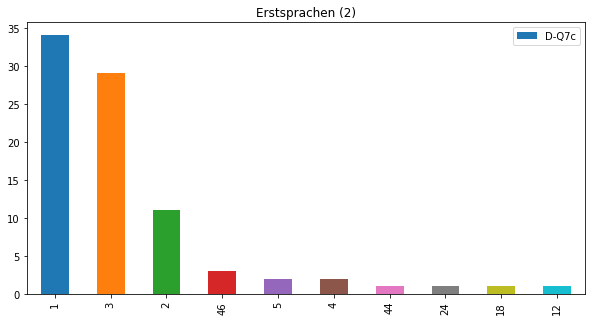

In [126]:
Finished[Finished['D-Q7c'] != 0]['D-Q7c'].value_counts().plot(kind='bar', figsize = (10,5), legend = True, title = "Erstsprachen (2)");

In [127]:
Finished[Finished['D-Q7c'] != 0]['D-Q7c'].value_counts()

1     34
3     29
2     11
46     3
5      2
4      2
44     1
24     1
18     1
12     1
Name: D-Q7c, dtype: int64

In [128]:
Finished[Finished['D-Q7e'] != 0]['D-Q7e'].value_counts()

2    83
1     3
Name: D-Q7e, dtype: int64

In [129]:
Finished[Finished['D-Q7f'] != 0]['D-Q7f'].value_counts()

3     1
46    1
Name: D-Q7f, dtype: int64

Otro = Guaraní

In [130]:
Sprachen = Finished[['D-Q8_1','D-Q8_2','D-Q8_3','D-Q8_4','D-Q8_5','D-Q8_6','D-Q8_7']]

In [131]:
DF_Spr = Sprachen.apply(pd.value_counts).fillna(0).astype(integer)

In [132]:
ix_sorted = list(DF_Spr[1:].sum(axis = 1).sort_values(ascending=False).index)

In [133]:
All = []
for i in DF_Spr.index:
    All.append((DF_Spr.loc[i]).sum())

In [134]:
DF_Spr['All'] = All

In [135]:
DF_Spr[1:]

,D-Q8_1,D-Q8_2,D-Q8_3,D-Q8_4,D-Q8_5,D-Q8_6,D-Q8_7,All
1,7,9,6,4,0,1,0,27
2,4,5,5,3,3,0,0,20
3,2,2,0,1,1,0,1,7
4,6,3,0,1,1,1,0,12
5,12,43,87,57,54,18,2,273
6,0,0,3,1,1,0,0,5
7,2,0,2,1,2,1,0,8
8,0,1,0,0,1,0,0,2
9,0,0,0,0,1,0,1,2
10,8,148,30,13,6,2,0,207


In [136]:
cols = ['D-Q8_1','D-Q8_2','D-Q8_3','D-Q8_4','D-Q8_5','D-Q8_6','D-Q8_7']

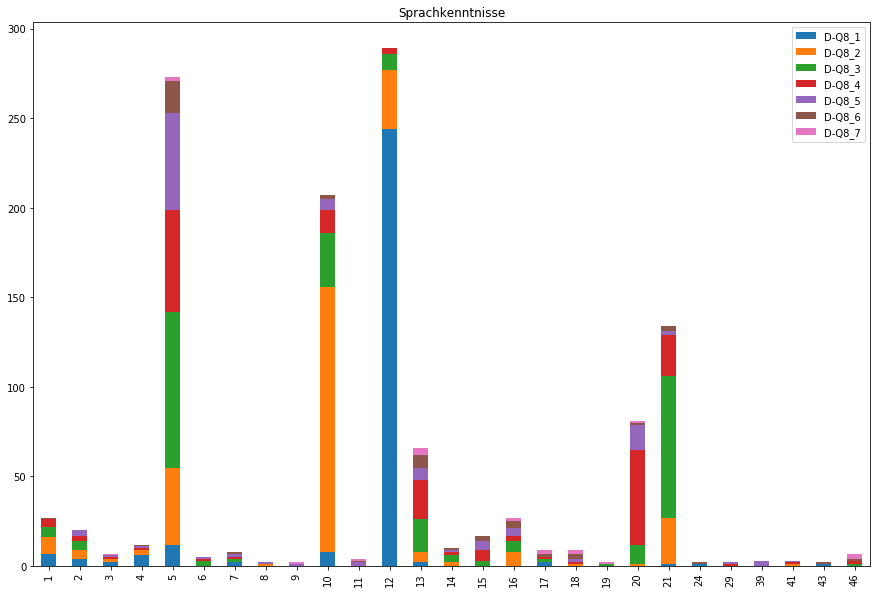

In [137]:
DF_Spr[cols][1:].plot(kind='bar', figsize = (15,10), stacked = True, legend = True, title = "Sprachkenntnisse");

In [138]:
DF_Spr.loc[ix_sorted[:10]]

,D-Q8_1,D-Q8_2,D-Q8_3,D-Q8_4,D-Q8_5,D-Q8_6,D-Q8_7,All
12,244,33,9,3,0,0,0,289
5,12,43,87,57,54,18,2,273
10,8,148,30,13,6,2,0,207
21,1,26,79,23,2,3,0,134
20,0,1,11,53,14,1,1,81
13,2,6,18,22,7,7,4,66
1,7,9,6,4,0,1,0,27
16,0,8,6,3,4,4,2,27
2,4,5,5,3,3,0,0,20
15,0,0,3,6,5,3,0,17


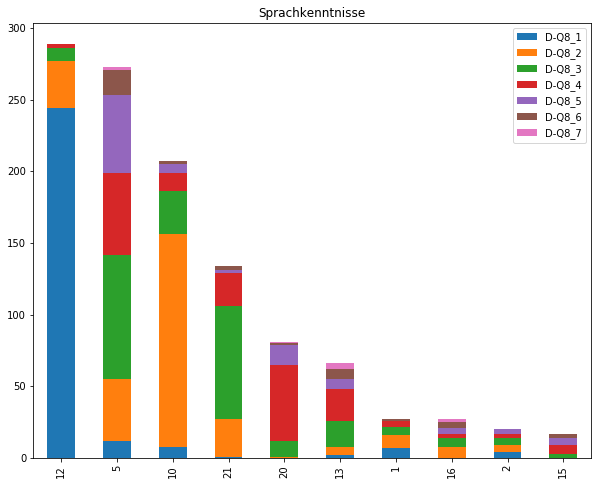

In [139]:
DF_Spr[cols].loc[ix_sorted[:10]].plot(kind='bar', figsize = (10,8), stacked = True, legend = True, title = "Sprachkenntnisse");

In [140]:
#Finished['D-Q9'].value_counts()[[1,2]].plot(kind = 'bar', figsize = (3,5), width = 0.4, legend = True, title = "Erhebungssituation");

(1)	Während der Unterrichtszeit,
(2)	Außerhalb des Unterrichts

In [141]:
Finished['D-Q9_1'].value_counts()

1    172
0    122
Name: D-Q9_1, dtype: int64

In [142]:
Finished['D-Q9_2'].value_counts()

0    171
1    123
Name: D-Q9_2, dtype: int64

In [143]:
pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

,a,b,c,d
0,0.870019,0.473451,0.845310,0.739387
1,0.878448,0.338470,0.674854,0.584817
2,0.690864,0.369990,0.807272,0.476740
3,0.483962,0.890070,0.263902,0.995530
4,0.839918,0.502068,0.322465,0.618325
5,0.107197,0.132959,0.998057,0.280647
6,0.145447,0.369743,0.796007,0.899554
7,0.357590,0.456698,0.737318,0.547710
8,0.458704,0.526032,0.546836,0.830320
9,0.468838,0.275414,0.266294,0.303032
